In [1]:
import os
import glob
import numpy as np
import pandas as pd
import random
import itertools
import pickle
from PIL import Image
import matplotlib.pyplot as plt

from utils.scale_crop import scale_img, center_crop_img
from utils.cam import CAM

from keras.models import load_model, Model
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics

Using TensorFlow backend.


### Loss and accuracy

In [2]:
model = load_model('./temp/loss_0.2529/model.hdf5')

/Users/olegpolakow/miniconda3/envs/py36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


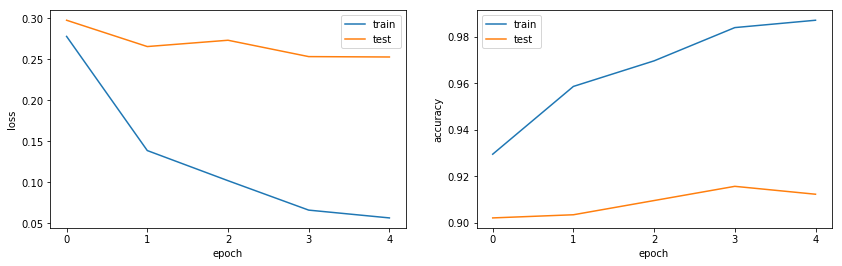

In [3]:
with open('./temp/loss_0.2529/fit_history.history', 'rb') as file_pi:
    history = pickle.load(file_pi)

def plot_loss_and_accuracy(history):
    # Plot the train and the validation loss and accuracy
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
    
    ax1.plot(history['loss'])
    ax1.plot(history['val_loss'])
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.set_xticks(range(len(history['acc'])))
    ax1.legend(['train', 'test'], loc='best')
    
    ax2.plot(history['acc'])
    ax2.plot(history['val_acc'])
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_xticks(range(len(history['acc'])))
    ax2.legend(['train', 'test'], loc='best')
    
    plt.show()
    
plot_loss_and_accuracy(history)

### Test images

In [4]:
# Global constants
IMG_SHAPE = (299, 299)
# Note that to avoid ImageDataGenerator iterator repeatability, we need to use 1 as batch_size.
BATCH_SIZE_TEST = 1

In [5]:
# Load the training data into the ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
testgen = datagen.flow_from_directory(
    './data/test',
    target_size=IMG_SHAPE,
    class_mode=None,
    batch_size=BATCH_SIZE_TEST,
    shuffle=False
)

Found 1479 images belonging to 120 classes.


In [6]:
# Reset before each call to predict
testgen.reset()

probs = model.predict_generator(testgen, steps=testgen.n//BATCH_SIZE_TEST, verbose=1)

1479/1479 [==============================] - 401s 271ms/step


### Evaluation metrics

In [7]:
# Predicted classes
preds = np.argmax(probs, axis=1).astype('int32')

print('Test accuracy:', metrics.accuracy_score(testgen.classes, preds))

Test accuracy: 0.9087221095334685


In [8]:
# Class names in order of their index
target_names = list(zip(*sorted(testgen.class_indices.items(), key=lambda x: x[1])))[0]

#print(metrics.classification_report(testgen.classes, preds, target_names=target_names, digits=3))

In [9]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#classes = list(map(lambda x: x[0], testgen.class_indices.items()))
#plot_confusion_matrix(cm, classes)

### Confused classes

In [10]:
# Map between classes and labels
class_indices = testgen.class_indices
class_map = dict((v, k) for k, v in class_indices.items())
class_map

def most_confused(cm):
    # Get dataframe of most confused labels
    cm_list = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                cm_list.append((class_map[i], class_map[j], cm[i, j]))
    df = pd.DataFrame(cm_list).sort_values(by=[2], ascending=False)
    return df

# Print the most misclassified labels
cm = metrics.confusion_matrix(testgen.classes, preds)
most_confused(cm).head()

,0,1,2
33,english_foxhound,walker_hound,3
27,collie,shetland_sheepdog,3
93,siberian_husky,eskimo_dog,3
91,shih-tzu,lhasa,3
75,miniature_poodle,toy_poodle,2


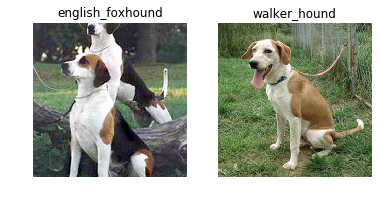

In [13]:
def imshow_random(*labels):
    # Compare random images of two or more labels
    rows = np.ceil(len(labels) / 5)
    f = plt.figure(figsize=(16, rows * 4))
    f.tight_layout()
    
    for i, label in enumerate(labels):
        sp = f.add_subplot(rows, 5, i+1)
        sp.axis('off')
        sp.set_title(label)
        
        fn = np.random.choice(glob.glob('data/test/{}/*'.format(label)))
        img = Image.open(fn)
        img = img.resize(IMG_SHAPE)
        plt.imshow(img)
        
imshow_random('english_foxhound', 'walker_hound')

In [14]:
def sort_by_mask(mask, ascending):
    # Return indices of sorted and masked probabilities
    idxs = np.where(mask)[0]
    mult = 1 if ascending else -1
    max_probs = np.max(probs, axis=1)
    return [idx for idx in np.argsort(mult * max_probs) if idx in idxs]

def imshow(idxs):
    # Show images specified by their indices in filenames
    rows = np.ceil(len(idxs) / 5)
    f = plt.figure(figsize=(16, rows * 4))
    f.tight_layout()
    
    for i, idx in enumerate(idxs):
        sp = f.add_subplot(rows, 5, i+1)
        sp.axis('off')
        
        true_label = class_map[testgen.classes[idx]]
        pred_label = class_map[preds[idx]]
        max_prob = np.max(probs[idx])
        sp.set_title("Pred: {} / {:.2f}\nTrue: {}".format(pred_label, max_prob, true_label))
        
        fn = 'data/test/' + testgen.filenames[idx]
        img = Image.open(fn)
        img = img.resize(IMG_SHAPE)
        plt.imshow(img)

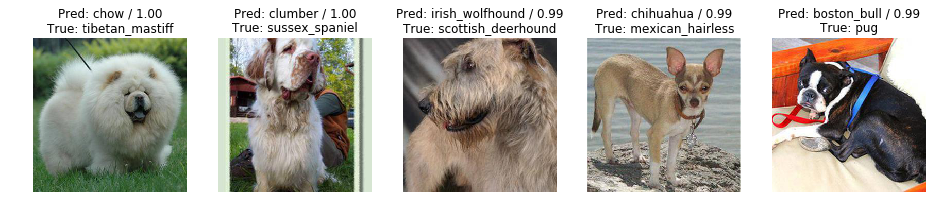

In [15]:
# Most incorrectly classified
imshow(sort_by_mask((preds != testgen.classes), False)[:5])

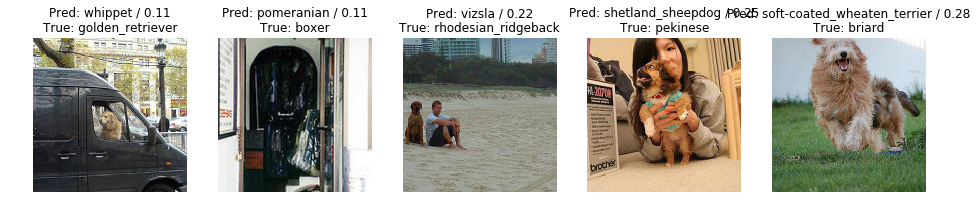

In [16]:
# Least incorrecly classified
imshow(sort_by_mask((preds != testgen.classes), True)[:5])

### Class activation map

[('shetland_sheepdog', 0.8476461), ('collie', 0.048488922), ('walker_hound', 0.03728213), ('pug', 0.018691631), ('english_foxhound', 0.009821555)]


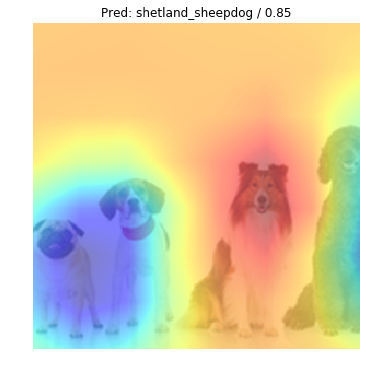

In [17]:
def display_cam(path, cam_class=None):
    # Display class activation map on image
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Preprocess image
    pre_img = Image.open(path)
    pre_img = scale_img(pre_img, IMG_SHAPE)
    pre_img = center_crop_img(pre_img, IMG_SHAPE)
    img = np.expand_dims(pre_img, axis=0)
    img = preprocess_input(img)
    
    # Classify image
    prob = model.predict(img)[0]
    top_pred = np.argsort(-prob).astype('int32')[:5]
    print([(class_map[p], prob[p]) for p in top_pred])
    pred = top_pred[0]
    pred_class = class_map[pred]
    pred_prob = prob[pred]
    
    if cam_class is None:
        cam_class = pred_class
    
    cam = CAM(img, model, class_indices[cam_class])
    ax.imshow(pre_img, alpha=0.5)
    ax.imshow(cam, cmap='jet', alpha=0.5)
    
    ax.axis('off')
    ax.set_title("Pred: {} / {:.2f}".format(pred_class, pred_prob))
    plt.show()
    
display_cam('dogs.jpg')